# VQ - VAE

## Import Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


## Define the VQ-VAE Model

In [4]:
class VQVAE(nn.Module):
    def __init__(self, input_channels, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()

        # Encoder (Compresses the input)
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, 4, stride=2, padding=1),  # Make image smaller
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.ReLU(),
        )

        # Codebook (like a dictionary of learned features)
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

        # Decoder (Reconstructs the image from compressed data)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, input_channels, 4, stride=2, padding=1),
            nn.Sigmoid(),  # Output values between 0 and 1
        )

    def forward(self, x):
        z_e = self.encoder(x)  # Compress the input
        z_e_flat = z_e.view(-1, self.embedding_dim)  # Flatten it

        # Find the nearest codebook vector (best match)
        distances = torch.sum(z_e_flat**2, dim=1, keepdim=True) + \
                    torch.sum(self.embedding.weight**2, dim=1) - \
                    2 * torch.matmul(z_e_flat, self.embedding.weight.t())

        # Pick the closest codebook index
        encoding_indices = torch.argmin(distances, dim=1)
        z_q = self.embedding(encoding_indices).view(z_e.shape)  # Get final compressed representation

        # Reconstruct the image
        x_recon = self.decoder(z_q)

        return x_recon, encoding_indices


## Define the Loss Function

In [24]:
def vq_vae_loss(x_recon, x, z_q, encoding_indices, beta=0.25):
    # Reconstruction loss
    recon_loss = F.mse_loss(x_recon, x)  # Calculate reconstruction loss (MSE loss)

    # Commitment loss (Forces the model to use all codebook values)
    z_q = z_q.float()  # Convert z_q to float (needed for MSE loss)
    commitment_loss = F.mse_loss(z_q, z_q.detach())  # Calculate commitment loss (MSE loss)

    # Total loss = Reconstruction + small penalty for ignoring codebook entries
    loss = recon_loss + beta * commitment_loss
    return loss

## Prepare the Dataset

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Split the data into train and validation sets
val_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


## Setup the Device (GPU/CPU)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Initialize the Model and Optimizer

In [39]:
model = VQVAE(input_channels=3, num_embeddings=512, embedding_dim=64)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

## Train the Model and Track Losses

In [40]:
# Model evaluation function
def evaluate(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            x, _ = data
            x = x.to(device).float()
            x_recon, z_q = model(x)
            loss = vq_vae_loss(x_recon, x, z_q, x)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [41]:
# Weight initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Apply weight initialization
model.apply(weights_init)

VQVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (embedding): Embedding(512, 64)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [42]:
# Early stopping setup
patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, verbose=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    # Training phase
    for data in train_loader:
        x, _ = data
        x = x.to(device).float()  # Convert to float

        optimizer.zero_grad()

        # Forward pass
        x_recon, z_q = model(x)

        # Convert z_q to float before loss calculation
        z_q = z_q.float()

        # Compute the loss
        loss = vq_vae_loss(x_recon, x, z_q, x)

        # Backward pass and optimization
        loss.backward()

        # Gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_train_loss += loss.item()

    # Average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    val_loss = evaluate(model, val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered. Stopping training.")
        break

    # Adjust the learning rate after validation loss
    scheduler.step(val_loss)

Epoch 1/20, Train Loss: 0.2483, Validation Loss: 0.2056
Epoch 2/20, Train Loss: 0.2051, Validation Loss: 0.2139
Epoch 3/20, Train Loss: 0.2120, Validation Loss: 0.2113
Epoch 4/20, Train Loss: 0.2096, Validation Loss: 0.2037
Epoch 5/20, Train Loss: 0.2033, Validation Loss: 0.1977
Epoch 6/20, Train Loss: 0.1973, Validation Loss: 0.1922
Epoch 7/20, Train Loss: 0.1925, Validation Loss: 0.1878
Epoch 8/20, Train Loss: 0.1890, Validation Loss: 0.1853
Epoch 9/20, Train Loss: 0.1870, Validation Loss: 0.1835
Epoch 10/20, Train Loss: 0.1853, Validation Loss: 0.1820
Epoch 11/20, Train Loss: 0.1839, Validation Loss: 0.1809
Epoch 12/20, Train Loss: 0.1830, Validation Loss: 0.1802
Epoch 13/20, Train Loss: 0.1823, Validation Loss: 0.1793
Epoch 14/20, Train Loss: 0.1814, Validation Loss: 0.1783
Epoch 15/20, Train Loss: 0.1805, Validation Loss: 0.1776
Epoch 16/20, Train Loss: 0.1798, Validation Loss: 0.1769
Epoch 17/20, Train Loss: 0.1793, Validation Loss: 0.1766
Epoch 18/20, Train Loss: 0.1788, Validat

## Plot Training and Validation Loss

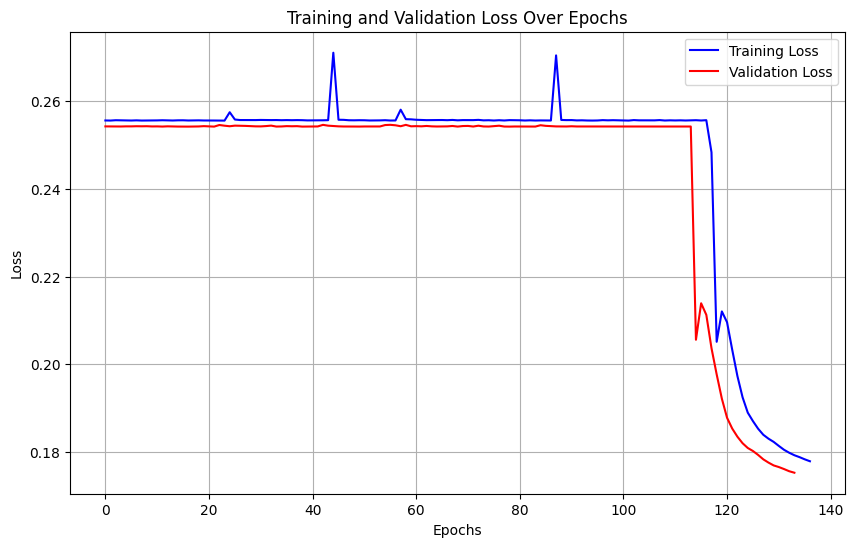

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Visualize Reconstructed Images

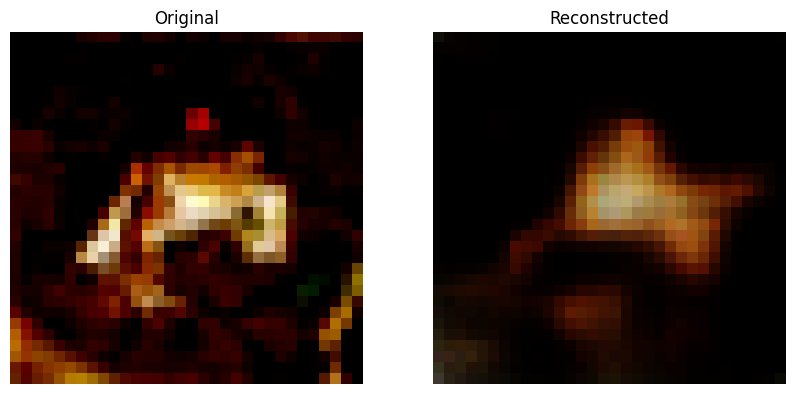

In [46]:
# Select an image from the training dataset
test_image, _ = train_dataset[0]  # Change index if you want a different image
test_image = test_image.unsqueeze(0).to(device)  # Add batch dimension and move to the correct device

# Set the model to evaluation mode and run inference without gradient tracking
model.eval()
with torch.no_grad():
    reconstructed_image, _ = model(test_image)  # Get the reconstructed image from the model

# Plot the original and reconstructed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axes[0].imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy())  # Convert from (C, H, W) to (H, W, C) for plotting
axes[0].set_title("Original")
axes[0].axis('off')  # Hide axes for cleaner visualization

# Reconstructed Image
axes[1].imshow(reconstructed_image.squeeze().permute(1, 2, 0).cpu().numpy())  # Convert from (C, H, W) to (H, W, C)
axes[1].set_title("Reconstructed")
axes[1].axis('off')  # Hide axes for cleaner visualization

# Display the images
plt.show()


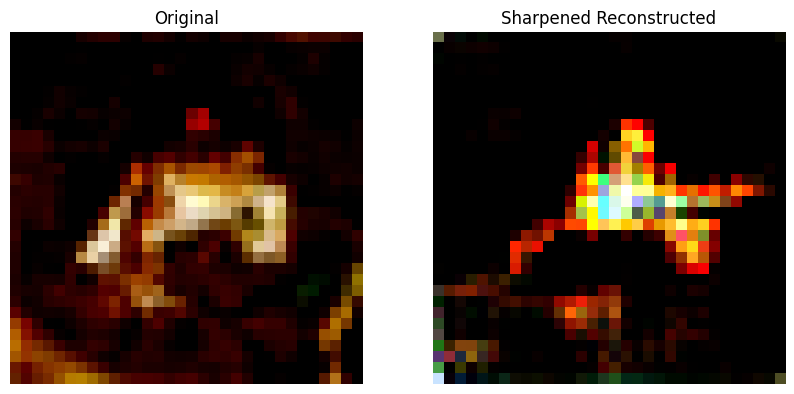

In [47]:
import cv2
import numpy as np

def sharpen_image(image):
    # Convert the image to numpy array
    image = image.squeeze().permute(1, 2, 0).cpu().numpy()

    # Normalize image to [0, 255]
    image = (image * 255).astype(np.uint8)

    # Create a sharpening kernel
    kernel = np.array([[-1, -1, -1], [-1,  9, -1], [-1, -1, -1]])

    # Apply the kernel using OpenCV filter2D
    sharpened_image = cv2.filter2D(image, -1, kernel)

    return sharpened_image

# Apply sharpening to the reconstructed image
sharpened_reconstructed_image = sharpen_image(reconstructed_image)

# Plot the original and sharpened reconstructed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axes[0].imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Original")
axes[0].axis('off')

# Sharpened Reconstructed Image
axes[1].imshow(sharpened_reconstructed_image)
axes[1].set_title("Sharpened Reconstructed")
axes[1].axis('off')

plt.show()